# AustinTrafficPy

## Team5_And_Dime (MWSa)

* Andry Dominguez
* Tony Jones
* Brian Stoller
* Ali Apil
* Eric Staveley


## Analysis

* xxx

* yyy

* zzz

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import gmaps



# import API keys as needed, incl Google developer
from api_keys import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/aus_traffic.csv"

#get current time
now = datetime.datetime.now()


#  ETL  STARTS HERE

In [2]:
#csv method...since we could get a larger dataset
data_file = "Resources/Real-Time_Traffic_Incident_Reports.csv"
#data_file = "//usaussfs2008.ad.global/home$/rstaveley/new_dir/Real-Time_Traffic_Incident_Reports.csv"
df_from_csv = pd.read_csv(data_file)
df_from_csv.head(20)

print(f"Raw data record count: {len(df_from_csv)}")


Raw data record count: 98324


In [3]:
#clean up the data

#get rid of the NaNs found in Location
#19	9BD7909EA32C89F68E82ED0CBE1F30A2E1D72B1C_15323...	07/23/2018 09:39:17 PM +0000	zSTALLED VEHICLE	NaN	0.000000	0.000000	3339 W BRAKER LN	ARCHIVED	07/23/2018 10:15:02 PM +0000

print(f"Non-NA values per column:\n{df_from_csv.count()}")   #show the non-NA cells for each field

#remove the rows with any empty cells
df_from_csv_clean = df_from_csv.dropna(how='any')

print(f"Total of rows with complete data now: {len(df_from_csv_clean)}")

print("Removing invalid longitude and latitude...")
#ensure lat and long are valid.  -90<=lat<=90     -180<=lon<=180
#lat
row_condition = df_from_csv_clean["Latitude"] <= 90
filtered_df = df_from_csv_clean.loc[row_condition]
row_condition = filtered_df["Latitude"] >= -90
filtered_df = filtered_df.loc[row_condition]

#long
row_condition = filtered_df["Longitude"] <= 180
filtered_df = filtered_df.loc[row_condition]
row_condition = filtered_df["Longitude"] >= -180
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with valid lat/long data: {len(filtered_df)}")
df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name

df_from_csv_clean.dtypes

Non-NA values per column:
Traffic Report ID    98324
Published Date       98324
Issue Reported       98324
Location             98045
Latitude             98245
Longitude            98245
Address              98324
Status               96631
Status Date          98324
dtype: int64
Total of rows with complete data now: 96358
Removing invalid longitude and latitude...
Total number of rows with valid lat/long data: 96352


Traffic Report ID     object
Published Date        object
Issue Reported        object
Location              object
Latitude             float64
Longitude            float64
Address               object
Status                object
Status Date           object
dtype: object

In [4]:
#df_from_csv_clean.count() 

In [5]:
#convert the date strings in the DF to valid datetime types
df_from_csv_clean['Published Date'] =  pd.to_datetime(df_from_csv_clean['Published Date'])
#df_from_csv_clean.head()
df_from_csv_clean['Status Date'] =  pd.to_datetime(df_from_csv_clean['Status Date'])
df_from_csv_clean.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03
1,2664C206999E7419517EE39E177797576A52201B_15381...,2018-09-29 00:52:58,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,2018-09-29 01:35:03
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,2018-12-03 17:49:02,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,2018-12-03 18:30:03
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,2018-09-29 12:47:30,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,2018-09-29 13:00:03


In [6]:
#peek at the earliest and latest date in our DF
earliest_date = min(df_from_csv_clean["Published Date"])
print(f"Earliest date: {earliest_date}")
latest_date = max(df_from_csv_clean["Published Date"])
print(f"Latest date: {latest_date}")
type(latest_date)     #confirm the type

df_from_csv_clean.dtypes


Earliest date: 2017-09-26 16:11:00
Latest date: 2019-03-06 02:37:18


Traffic Report ID            object
Published Date       datetime64[ns]
Issue Reported               object
Location                     object
Latitude                    float64
Longitude                   float64
Address                      object
Status                       object
Status Date          datetime64[ns]
dtype: object

In [7]:
#use only 2018 data now
#keep only 2018 data
row_condition = df_from_csv_clean["Published Date"] <= "2018-12-31 23:59:59"
filtered_df = filtered_df.loc[row_condition]
row_condition = filtered_df["Published Date"] >= "2018-01-01 00:00:01"
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with 2018 data  {len(filtered_df)}")
df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name


Total number of rows with 2018 data  68244


In [8]:
#only use 2018 data now
#
#year_mask = (df_from_csv_clean["Published Date"].dt.year > 2017) & \
#            (df_from_csv_clean["Published Date"].dt.year < 2019)
#filtered_df = df_from_csv_clean[year_mask]

#print(f"Total number of rows with 2018 data  {len(year_mask_df)}")
#df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name




In [9]:
#look at types of accidents and counts
df_from_csv_clean["Issue Reported"].value_counts()

Traffic Hazard                20272
Crash Urgent                  15411
Crash Service                 11343
COLLISION                      4793
Traffic Impediment             4745
TRFC HAZD/ DEBRIS              4060
zSTALLED VEHICLE               3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
BLOCKED DRIV/ HWY                93
ICY ROADWAY                      21
BOAT ACCIDENT                    20
AUTO/ PED                        15
TRAFFIC FATALITY                 11
FLEET ACC/ INJURY                 9
N / HZRD TRFC VIOL                2
HIGH WATER                        1
COLLISN / FTSRA                   1
Name: Issue Reported, dtype: int64

In [10]:
#clean up col names,  and make "Other" from bott group
renamed_df = df_from_csv_clean.replace({"HIGH WATER" : "OTHER", "COLLISN / FTSRA":"OTHER", "N / HZRD TRFC VIOL":"OTHER","FLEET ACC/ INJURY":"OTHER" , "AUTO/ PED" : "OTHER", "BOAT ACIDENT":"OTHER", "ICY ROADWAY":"OTHER","BLOCKED DRIV/ HWY":"OTHER" })
df_from_csv_clean = renamed_df.replace({"zSTALLED VEHICLE" : "STALLED VEHICLE", "Traffic Hazard":"TRAFFIC HAZARD", "Crash Urgent":"CRASH URGENT", "Crash Service":"CRASH SERVICE", "Traffic Impediment":"TRAFFIC IMPEDIMENT"  })

#Verify cleanup
df_from_csv_clean["Issue Reported"].value_counts()
x= df_from_csv_clean["Issue Reported"].value_counts()
print(x)
#x[0]
#x[1]
#we now will dive into 
#'Crash Urgent', 'Crash Service', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/Private Property', 'TRAFFIC FATALITY')
#print(f"Total number of rows with 2018 data  {len(renamed_df)}")

TRAFFIC HAZARD                20272
CRASH URGENT                  15411
CRASH SERVICE                 11343
COLLISION                      4793
TRAFFIC IMPEDIMENT             4745
TRFC HAZD/ DEBRIS              4060
STALLED VEHICLE                3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
OTHER                           142
BOAT ACCIDENT                    20
TRAFFIC FATALITY                 11
Name: Issue Reported, dtype: int64


([<matplotlib.patches.Wedge at 0xc7421fd400>,
 [Text(-1.166993757679846, -0.2795095160030752, 'TRAFFIC HAZARD'),
  Text(0.33236167117831206, -1.0485874877813295, 'CRASH URGENT'),
  Text(1.0994283816649344, -0.03545748989457086, 'CRASH SERVICE'),
  Text(0.8337846585299421, 0.7174978349793873, 'COLLISION'),
  Text(0.4496821428952587, 1.003885436870726, 'TRAFFIC IMPEDIMENT'),
  Text(0.017385122560072123, 1.099862608471427, 'TRFC HAZD/ DEBRIS'),
  Text(-0.3351119265076546, 1.0477117908625104, 'STALLED VEHICLE'),
  Text(-0.5470005370705541, 0.954353400184924, 'COLLISION WITH INJURY'),
  Text(-0.6749347486261855, 0.8685983450921996, 'LOOSE LIVESTOCK'),
  Text(-0.7691644603631717, 0.7863752494288151, 'COLLISN/ LVNG SCN'),
  Text(-0.8131170926017822, 0.7408377647763543, 'COLLISION/PRIVATE PROPERTY'),
  Text(-0.826453105280294, 0.7259306198064382, 'VEHICLE FIRE'),
  Text(-0.8359716634535844, 0.7149485141621369, 'OTHER'),
  Text(-0.8412801838023155, 0.7086943292714727, 'BOAT ACCIDENT'),
  Text(-

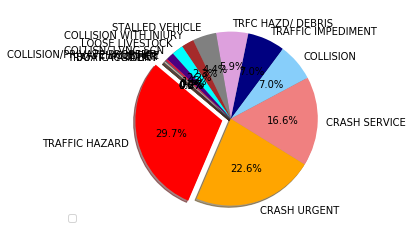

In [19]:
#type(x)
#print(x[0])
#print(x)
#print(x.index)
#type(x.index)
 
labels = df_from_csv_clean['Issue Reported'].value_counts().index
values = df_from_csv_clean['Issue Reported'].value_counts().values
colors = ["red", "orange", "lightcoral", "lightskyblue", "navy", "plum", "grey", "brown", "aqua", "indigo", "crimson", "dimgray", "silver", "orange", "lightcoral"]
explode = (0.1, 0, 0, 0, 0, 0, 0,0, 0, 0,0, 0, 0,0, 0, )
plt.axis("equal")
plt.legend(labels, loc=3)

plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)




In [12]:
x = df_from_csv_clean["Issue Reported"].value_counts()
type(x)

pandas.core.series.Series

In [13]:
x["COLLISION"]

4793

In [14]:
x[0]

20272


# Define df's for team member's plotting use

In [54]:
#we will subdivide into these Issues Reported:
#Crash Urgent, Crash Service, COLLISION, COLLISION WITH INJURY, COLLISN/ LVNG SCN, COLLISION/PRIVATE PROPERTY, TRAFFIC FATALITY
analysis_issues = ('Crash Urgent', 'Crash Service', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/Private Property', 'TRAFFIC FATALITY')
analysis_df = filtered_df[filtered_df['Issue Reported'].isin(analysis_issues)]
# analysis_df.tail()
len(analysis_df)

34131

In [19]:
am_time_mask = (analysis_df['Published Date'].dt.hour >= 0) & \
           (analysis_df['Published Date'].dt.hour <= 5)
am_report_df = analysis_df[am_time_mask]
# am_report_df.head()

In [20]:
mid_time_mask = (analysis_df['Published Date'].dt.hour >= 9) & \
           (analysis_df['Published Date'].dt.hour <= 15)
mid_report_df = analysis_df[mid_time_mask]
# mid_report_df.head()

In [21]:
pm_time_mask = (analysis_df['Published Date'].dt.hour >= 19) & \
           (analysis_df['Published Date'].dt.hour <= 24)
pm_report_df = analysis_df[pm_time_mask]
# pm_report_df.head()

In [22]:
non_rush_1_df = am_report_df.append(mid_report_df, ignore_index=True)
# non_rush_1_df.head()

In [23]:
non_rush_df = non_rush_1_df.append(pm_report_df, ignore_index=True)
non_rush_df.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,69E356FC5B897FF52301D1A4D870E2862A05C244_15324...,2018-07-24 05:40:48,COLLISION,"(30.094498,-97.761155)",30.094498,-97.761155,6700-7940 S SH 45 E WB,ARCHIVED,2018-07-24 06:45:02
1,B039469E10CC32B9EB6AAEE8AABB64A15836746F_15381...,2018-09-29 00:58:05,Crash Service,"(30.287391,-97.741586)",30.287391,-97.741586,2340 Guadalupe St,ARCHIVED,2018-09-29 01:40:03
2,A0A82EBDD4A855C999B56CE855A244A672DCAFFF_15381...,2018-09-29 00:54:38,Crash Service,"(30.225971,-97.804548)",30.225971,-97.804548,Jones Rd & West Wind Trl,ARCHIVED,2018-09-29 02:10:03
3,08D67B9F9F6E2794FD86FD4B7E70E8360CCDBEAD_15381...,2018-09-29 02:37:20,Crash Service,"(30.311435,-97.709675)",30.311435,-97.709675,5200-5226 N Ih 35 Svrd Sb,ARCHIVED,2018-09-29 03:10:02
4,1D533EC2E7D744E1AC9A2E874A5F269093234DF3_15382...,2018-09-30 05:04:56,Crash Urgent,"(30.411702,-97.722008)",30.411702,-97.722008,Amherst Dr & Duval Rd,ARCHIVED,2018-09-30 06:05:02


In [24]:
non_rush_df.count()

Traffic Report ID    24666
Published Date       24666
Issue Reported       24666
Location             24666
Latitude             24666
Longitude            24666
Address              24666
Status               24666
Status Date          24666
dtype: int64

# BY MONTH

In [25]:
# Filter analysis df by month for plotting
# Generate January report
jan_mask = (analysis_df['Published Date'].dt.month == 1)
jan_report_df = analysis_df[jan_mask]
jan_count = jan_report_df['Published Date'].count()

In [26]:
# Generate February report
feb_mask = (analysis_df['Published Date'].dt.month == 2)
feb_report_df = analysis_df[feb_mask]
feb_count = feb_report_df['Published Date'].count()

In [27]:
# Generate March report
mar_mask = (analysis_df['Published Date'].dt.month == 3)
mar_report_df = analysis_df[mar_mask]
mar_count = mar_report_df['Published Date'].count()

In [28]:
# Generate April report
apr_mask = (analysis_df['Published Date'].dt.month == 4)
apr_report_df = analysis_df[apr_mask]
apr_count = apr_report_df['Published Date'].count()

In [29]:
# Generate May report
may_mask = (analysis_df['Published Date'].dt.month == 5)
may_report_df = analysis_df[may_mask]
may_count = may_report_df['Published Date'].count()

In [30]:
# Generate June report
jun_mask = (analysis_df['Published Date'].dt.month == 6)
jun_report_df = analysis_df[jun_mask]
jun_count = jun_report_df['Published Date'].count()

In [31]:
# Generate July report
jul_mask = (analysis_df['Published Date'].dt.month == 7)
jul_report_df = analysis_df[jul_mask]
jul_count = jul_report_df['Published Date'].count()

In [32]:
# Generate August report
aug_mask = (analysis_df['Published Date'].dt.month == 8)
aug_report_df = analysis_df[aug_mask]
aug_count = aug_report_df['Published Date'].count()

In [33]:
# Generate September report
sep_mask = (analysis_df['Published Date'].dt.month == 9)
sep_report_df = analysis_df[sep_mask]
sep_count = sep_report_df['Published Date'].count()

In [34]:
# Generate October report
oct_mask = (analysis_df['Published Date'].dt.month == 10)
oct_report_df = analysis_df[oct_mask]
oct_count = oct_report_df['Published Date'].count()

In [35]:
# Generate November report
nov_mask = (analysis_df['Published Date'].dt.month == 11)
nov_report_df = analysis_df[nov_mask]
nov_count = nov_report_df['Published Date'].count()

In [36]:
# Generate December report
dec_mask = (analysis_df['Published Date'].dt.month == 12)
dec_report_df = analysis_df[dec_mask]
dec_count = dec_report_df['Published Date'].count()
#dec_count

In [37]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
accidents = [
    jan_count, feb_count, mar_count, apr_count, may_count, jun_count,
    jul_count, aug_count, sep_count, oct_count, nov_count, dec_count
]

x_axis = np.arange(len(months))

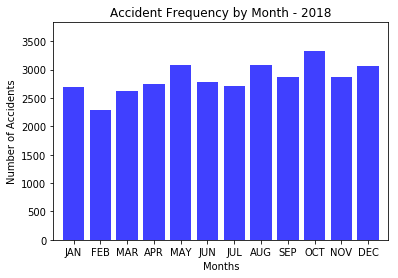

In [38]:
# Create a bar chart based upon the above data
plt.bar(x_axis, accidents, color="blue", alpha=0.75, align="center")
# Create the ticks for our bar chart's x axis
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, (months))
# Set the limits of the x axis
plt.xlim(-0.75, len(x_axis)-0.25)
# Set the limits of the y axis
plt.ylim(0, max(accidents)+500)
# Give the chart a title, x label, and y label
plt.title("Accident Frequency by Month - 2018")
plt.xlabel("Months")
plt.ylabel("Number of Accidents")
# Save an image of the chart and print it to the screen
plt.savefig("output_data/MonthComparison.png")


# BY DAY

In [39]:
# Filter analysis df by day of week for plotting
# Generate Monday report
mon_mask = (analysis_df['Published Date'].dt.dayofweek == 0)
mon_report_df = analysis_df[mon_mask]
mon_count = mon_report_df['Published Date'].count()
# mon_report_df.tail()
mon_count

4996

In [40]:
# Generate Tuesday report
tue_mask = (analysis_df['Published Date'].dt.dayofweek == 1)
tue_report_df = analysis_df[tue_mask]
tue_count = tue_report_df['Published Date'].count()
# tue_report_df.tail()
tue_count

5101

In [41]:
# Generate Wednesday report
wed_mask = (analysis_df['Published Date'].dt.dayofweek == 2)
wed_report_df = analysis_df[wed_mask]
wed_count = wed_report_df['Published Date'].count()
# wed_report_df.tail()
wed_count

5132

In [42]:
# Generate Thursday report
thu_mask = (analysis_df['Published Date'].dt.dayofweek == 3)
thu_report_df = analysis_df[thu_mask]
thu_count = thu_report_df['Published Date'].count()
# thu_report_df.tail()
thu_count

5174

In [43]:
# Generate Friday report
fri_mask = (analysis_df['Published Date'].dt.dayofweek == 4)
fri_report_df = analysis_df[fri_mask]
fri_count = fri_report_df['Published Date'].count()
# fri_report_df.tail()
fri_count

5708

In [44]:
# Generate Saturday report
sat_mask = (analysis_df['Published Date'].dt.dayofweek == 5)
sat_report_df = analysis_df[sat_mask]
sat_count = sat_report_df['Published Date'].count()
# sat_report_df.tail()
sat_count

4452

In [45]:
# Generate Sunday report
sun_mask = (analysis_df['Published Date'].dt.dayofweek == 6)
sun_report_df = analysis_df[sun_mask]
sun_count = sun_report_df['Published Date'].count()
# sun_report_df.tail()
sun_count

3568

In [46]:
days = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
accident_days = [
    mon_count, tue_count, wed_count, thu_count, fri_count, sat_count, sun_count
]

x_axis_days = np.arange(len(days))

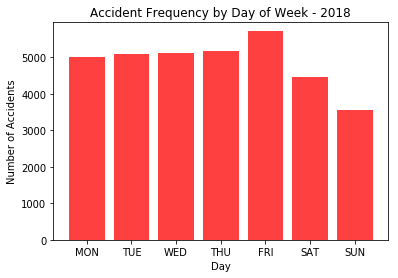

In [47]:
# Create a bar chart based upon the above data
plt.figure(2)
plt.bar(x_axis_days, accident_days, color="red", alpha=0.75, align="center")
# Create the ticks for our bar chart's x axis
tick_locations = [value for value in x_axis_days]
plt.xticks(tick_locations, (days))
# Set the limits of the x axis
plt.xlim(-0.75, len(x_axis_days)-0.25)
# Set the limits of the y axis
plt.ylim(0, max(accident_days)+250)
# Give the chart a title, x label, and y label
plt.title("Accident Frequency by Day of Week - 2018")
plt.xlabel("Day")
plt.ylabel("Number of Accidents")
# Save an image of the chart and print it to the screen
plt.savefig("output_data/DayOfWeekComparison.png")

In [48]:
# code to take the lat and long and make a list for gmap

aus_lat = df_from_csv_clean["Latitude"]    #series
aus_long = df_from_csv_clean["Longitude"]    #series

aus_lat_subset = aus_lat.head(1000)   #make a subset to test
aus_long_subset = aus_long.head(1000)  # make a subset to test

#print(type(aus_lat_subset))     #its a series
#print(aus_lat_subset[0])        #whats the value?
#print(type(aus_lat_subset[0]))    #its a string

#print(aus_lat_subset)   #show the whole lat subset

#using zip function to zip the lat and long together to a list with each element being a tuple
aus_lat_long_list_subset = list(zip(aus_lat_subset, aus_long_subset))
aus_lat_long_list = list(zip(aus_lat, aus_long))

#print(aus_lat_long_list_subset)
#type(aus_lat_long_list_subset[0])    #each element is a tuple...yay!

In [49]:
# Customize the size of the figure      was   400 x 300
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [50]:
# Assign the marker layer to a variable  ..      DOING THE SUBSET HERE... TAKES ABOUT 10sec  

#help(gmaps.marker_layer)

markers = gmaps.marker_layer(aus_lat_long_list_subset)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [51]:
#help(gmaps.marker_layer)
#extracting the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!


In [52]:
fig = gmaps.figure(map_type='HYBRID')
heatmap_layer = gmaps.heatmap_layer(aus_lat_long_list_subset)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [53]:
#saving the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!